# Multimodal Deep Learning Pipeline for Spatial Transcriptomics

This notebook builds and trains a multimodal deep learning model that integrates spatial transcriptomics data with corresponding histology images.

*Author: Pedram Torabian*
*Last updated: 2025-04-23*

## 1. Environment Setup

There is a 'requirement.txt' file in the directory that can be used to install the required packages.

# Ultimate goals:
Build a multi‑modal VAE that fuses histology, spatial transcriptomics, and coordinates into a biologically meaningful latent space, can reconstruct or impute any missing modality, and model disease progression from normal pancreas through primary tumor to metastatic niches.

## 2. Library Imports

In [3]:
import squidpy as sq
print(sq.__version__)

1.2.3


## 3. Data Loading and Basic Inspection

In [4]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

# Load the dataset
print("Loading the dataset...")
adata = ad.read_h5ad("spatial_with_images.h5ad")

# Print basic information
print("\n=== Basic Information ===")
print(f"AnnData object with n_obs × n_vars = {adata.n_obs} × {adata.n_vars}")

# Check for spatial coordinates in obsm
print("\n=== Spatial Coordinates ===")
print(f"Keys in obsm: {list(adata.obsm.keys())}")
for key in adata.obsm.keys():
    shape = adata.obsm[key].shape
    print(f"  - {key}: shape {shape}")

# Check for image data in uns
print("\n=== Image Data ===")
print(f"Keys in uns: {list(adata.uns.keys())}")

# Look for spatial information in uns
spatial_keys = []
for key in adata.uns.keys():
    if isinstance(adata.uns[key], dict):
        if 'images' in adata.uns[key] or 'image' in adata.uns[key]:
            spatial_keys.append(key)
            
print(f"Potential spatial keys: {spatial_keys}")

# Inspect first spatial key if available
if spatial_keys:
    first_key = spatial_keys[0]
    print(f"\nInspecting uns['{first_key}']:")
    
    try:
        # This section tries different structures that might exist
        if isinstance(adata.uns[first_key], dict):
            print(f"  - Keys: {list(adata.uns[first_key].keys())}")
            
            # Check if it's a dictionary with library_id keys
            if any(k for k in adata.uns[first_key].keys() if k != 'images' and k != 'scalefactors'):
                # Visium-style format with library ID
                first_lib_id = [k for k in adata.uns[first_key].keys() 
                               if k != 'images' and k != 'scalefactors'][0]
                print(f"  - Library ID: {first_lib_id}")
                
                if 'images' in adata.uns[first_key][first_lib_id]:
                    print(f"  - Image keys: {list(adata.uns[first_key][first_lib_id]['images'].keys())}")
                
                if 'scalefactors' in adata.uns[first_key][first_lib_id]:
                    print(f"  - Scalefactor keys: {list(adata.uns[first_key][first_lib_id]['scalefactors'].keys())}")
            
            # Direct images dictionary
            elif 'images' in adata.uns[first_key]:
                print(f"  - Image keys: {list(adata.uns[first_key]['images'].keys())}")
                
                # Check image shapes
                for img_key in adata.uns[first_key]['images'].keys():
                    img = adata.uns[first_key]['images'][img_key]
                    print(f"    - {img_key} shape: {img.shape}")
                
            if 'scalefactors' in adata.uns[first_key]:
                print(f"  - Scalefactor keys: {list(adata.uns[first_key]['scalefactors'].keys())}")
    except Exception as e:
        print(f"Error inspecting spatial data: {e}")

# Check for obsm spatial coordinates
spatial_coord_keys = [key for key in adata.obsm.keys() 
                     if 'spatial' in key.lower() or 'coord' in key.lower()]

if spatial_coord_keys:
    print("\n=== Spatial Coordinates ===")
    for key in spatial_coord_keys:
        coords = adata.obsm[key]
        print(f"  - {key}: shape {coords.shape}")
        print(f"    - First 5 coordinates: {coords[:5]}")

# Check if there are any clustering results
print("\n=== Existing Annotations/Clusters ===")
print(f"Keys in obs: {list(adata.obs.columns)}")
cluster_cols = [col for col in adata.obs.columns if 'cluster' in col.lower() or 'group' in col.lower() or 'type' in col.lower()]
if cluster_cols:
    print(f"Potential cluster columns: {cluster_cols}")
    for col in cluster_cols[:2]:  # Show first 2 only
        print(f"  - {col} value counts:")
        print(adata.obs[col].value_counts().head())

print("\nData exploration complete!")

Loading the dataset...

=== Basic Information ===
AnnData object with n_obs × n_vars = 91496 × 17860

=== Spatial Coordinates ===
Keys in obsm: ['X_integrated', 'spatial_IU_PDA_HM10', 'spatial_IU_PDA_HM11', 'spatial_IU_PDA_HM12', 'spatial_IU_PDA_HM13', 'spatial_IU_PDA_HM2', 'spatial_IU_PDA_HM2_2', 'spatial_IU_PDA_HM3', 'spatial_IU_PDA_HM4', 'spatial_IU_PDA_HM5', 'spatial_IU_PDA_HM6', 'spatial_IU_PDA_HM8', 'spatial_IU_PDA_HM9', 'spatial_IU_PDA_LNM10', 'spatial_IU_PDA_LNM12', 'spatial_IU_PDA_LNM6', 'spatial_IU_PDA_LNM7', 'spatial_IU_PDA_LNM8', 'spatial_IU_PDA_NP10', 'spatial_IU_PDA_NP11', 'spatial_IU_PDA_NP2', 'spatial_IU_PDA_T1', 'spatial_IU_PDA_T10', 'spatial_IU_PDA_T11', 'spatial_IU_PDA_T12', 'spatial_IU_PDA_T2', 'spatial_IU_PDA_T3', 'spatial_IU_PDA_T4', 'spatial_IU_PDA_T6', 'spatial_IU_PDA_T8', 'spatial_IU_PDA_T9']
  - X_integrated: shape (91496, 3000)
  - spatial_IU_PDA_HM10: shape (91496, 2)
  - spatial_IU_PDA_HM11: shape (91496, 2)
  - spatial_IU_PDA_HM12: shape (91496, 2)
  - spa

### To see the spatial object structure

### list of sample types:

#### HM: Hepatic met.

#### LNM: Lymph node met.

#### NP: Normal pancreas

#### T: primary tumor

### To make sure how many samples are having spatial coords and images:

In [5]:
from pathlib import Path
import numpy as np

libs_with_image, libs_without_image = [], []

def has_image(entry):
    """Return True if `entry` is a valid path OR an in‑memory image array."""
    if entry is None:
        return False
    # 1) path‑like (string or Path)
    if isinstance(entry, (str, Path)):
        return Path(entry).expanduser().exists()
    # 2) ndarray (hires image stored in the AnnData)
    if isinstance(entry, (np.ndarray,)):
        return entry.size > 0
    # 3) PIL image, xarray.DataArray, etc. – just assume it’s valid
    return True

for lib_id, meta in adata.uns.get("spatial", {}).items():
    img_entry = meta.get("images", {}).get("hires")  # or "lowres"
    img_ok    = has_image(img_entry)

    key = f"spatial_{lib_id}"
    coords_ok = (
        key in adata.obsm and
        (~np.isnan(adata.obsm[key][:, 0])).any()
    )

    (libs_with_image if img_ok and coords_ok else libs_without_image).append(lib_id)

print("=== libraries with usable image & coords ===")
print("\n".join(f" • {lib}" for lib in libs_with_image) or "None")

print("\n=== libraries missing image or coords ===")
print("\n".join(f" • {lib}" for lib in libs_without_image) or "None")

=== libraries with usable image & coords ===
 • IU_PDA_HM10
 • IU_PDA_HM11
 • IU_PDA_HM12
 • IU_PDA_HM13
 • IU_PDA_HM2
 • IU_PDA_HM2_2
 • IU_PDA_HM3
 • IU_PDA_HM4
 • IU_PDA_HM5
 • IU_PDA_HM6
 • IU_PDA_HM8
 • IU_PDA_HM9
 • IU_PDA_LNM10
 • IU_PDA_LNM12
 • IU_PDA_LNM6
 • IU_PDA_LNM7
 • IU_PDA_LNM8
 • IU_PDA_NP10
 • IU_PDA_NP11
 • IU_PDA_NP2
 • IU_PDA_T1
 • IU_PDA_T10
 • IU_PDA_T11
 • IU_PDA_T12
 • IU_PDA_T2
 • IU_PDA_T3
 • IU_PDA_T4
 • IU_PDA_T6
 • IU_PDA_T8
 • IU_PDA_T9

=== libraries missing image or coords ===
None


In [6]:
unique_slides = libs_with_image

In [7]:
# Find where valid coordinates are located for each slide
for slide in unique_slides[:5]:  # Check first 5 slides as example
    spatial_key = f'spatial_{slide}'
    
    # Find indices with valid coordinates
    valid_mask = ~np.isnan(adata.obsm[spatial_key]).any(axis=1)
    num_valid = np.sum(valid_mask)
    
    # Get valid coordinates
    valid_coords = adata.obsm[spatial_key][valid_mask]
    
    print(f"\nSlide {slide}:")
    print(f"  Valid coordinates: {num_valid} out of {adata.obsm[spatial_key].shape[0]}")
    if num_valid > 0:
        print(f"  First 3 valid coordinates: {valid_coords[:3]}")
        
        # Get indices of valid coordinates
        valid_indices = np.where(valid_mask)[0]
        print(f"  Located at indices: {valid_indices[:3]}...")


Slide IU_PDA_HM10:
  Valid coordinates: 2348 out of 91496
  First 3 valid coordinates: [[11750.  5932.]
 [ 3323.  4360.]
 [ 2719.  6480.]]
  Located at indices: [1908 1909 1910]...

Slide IU_PDA_HM11:
  Valid coordinates: 3931 out of 91496
  First 3 valid coordinates: [[15841. 10096.]
 [ 4608.  7971.]
 [14754. 18574.]]
  Located at indices: [4256 4257 4258]...

Slide IU_PDA_HM12:
  Valid coordinates: 2961 out of 91496
  First 3 valid coordinates: [[8333. 4588.]
 [7781. 8827.]
 [7997. 3291.]]
  Located at indices: [8187 8188 8189]...

Slide IU_PDA_HM13:
  Valid coordinates: 2182 out of 91496
  First 3 valid coordinates: [[ 5056.  6369.]
 [15196. 16963.]
 [ 3702. 10134.]]
  Located at indices: [11148 11149 11150]...

Slide IU_PDA_HM2:
  Valid coordinates: 2478 out of 91496
  First 3 valid coordinates: [[ 8721. 19618.]
 [15621. 17036.]
 [ 8736.  3146.]]
  Located at indices: [13330 13331 13332]...


### List od slide IDs:

In [8]:
import numpy as np

# ---- 1. empty vector the size of n_obs ----
slide_ids = np.empty(adata.n_obs, dtype=object)

# ---- 2. loop over the 30 libraries ----
for lib_id in adata.uns["spatial"].keys():          # e.g. "IU_PDA_T9"
    coords = adata.obsm.get(f"spatial_{lib_id}")
    if coords is None:               # should not happen
        continue
    mask = ~np.isnan(coords[:, 0])   # True for spots coming from this slide
    slide_ids[mask] = lib_id

# ---- 3. sanity check ----
assert (slide_ids != None).all(), "some spots remain unassigned"
print("recovered slide_ids:", np.unique(slide_ids), " (total spots:", len(slide_ids), ")")

recovered slide_ids: ['IU_PDA_HM10' 'IU_PDA_HM11' 'IU_PDA_HM12' 'IU_PDA_HM13' 'IU_PDA_HM2'
 'IU_PDA_HM2_2' 'IU_PDA_HM3' 'IU_PDA_HM4' 'IU_PDA_HM5' 'IU_PDA_HM6'
 'IU_PDA_HM8' 'IU_PDA_HM9' 'IU_PDA_LNM10' 'IU_PDA_LNM12' 'IU_PDA_LNM6'
 'IU_PDA_LNM7' 'IU_PDA_LNM8' 'IU_PDA_NP10' 'IU_PDA_NP11' 'IU_PDA_NP2'
 'IU_PDA_T1' 'IU_PDA_T10' 'IU_PDA_T11' 'IU_PDA_T12' 'IU_PDA_T2'
 'IU_PDA_T3' 'IU_PDA_T4' 'IU_PDA_T6' 'IU_PDA_T8' 'IU_PDA_T9']  (total spots: 91496 )


In [9]:
adata.obs["slide_id"] = slide_ids

## 1. Map slides to 0 – 3 codes

In [10]:
import re, numpy as np

type_map = {"NP":0, "T":1, "HM":2, "LNM":3}

def tag_to_code(slide_id):
    tag = slide_id.split("_")[2]        # "HM9", "T10", ...
    tag = re.match(r"[A-Z]+", tag).group()   # keep only the letters: "HM"
    return type_map[tag]

sample_type_vec = np.fromiter(
    (tag_to_code(s) for s in slide_ids),
    dtype=np.int32,
    count=len(slide_ids)
)

# sanity‑check
counts = np.bincount(sample_type_vec, minlength=4)
print("NP, T, HM, LNM spot counts:", counts)

NP, T, HM, LNM spot counts: [ 9820 35458 28520 17698]


### Stage | Accomplished
Data plumbing |  All 91 496 spots now have: gene vector, (x , y) coords, 224 × 224 patch, slide‑ID, sample‑type code.
Three‑branch encoder |  CNN + MLP + xy network defined.
Auxiliary heads |  class_out (tissue label) and type_out (NP / T / HM / LNM) wired in.
Training dataset |  tf.data.Dataset streams images from patches.h5 and feeds all five inputs.

### Goal of the next runs: train a group‑aware latent that already tells healthy from tumour, etc. Then decide if I need the generative VAE extension.

### Train the encoder (A shared encoder learns modality fusion (patch + genes + coords) once)

### The auxiliary sample‑type head forces the latent to respect large biological classes (healthy vs tumour vs metastasis). That makes downstream clustering much cleaner.

In [11]:
# --- create genes_all & xy_all in RAM ---
import numpy as np
# 1. gene matrix  (log‑transform then float32)
genes_all = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
genes_all = np.log1p(genes_all).astype(np.float32)

# 2. spatial coords  (choose the correct key for each spot)
xy_all = np.column_stack([adata.obsm["X_spatial_x"], adata.obsm["X_spatial_y"]]) \
         if "X_spatial_x" in adata.obsm else adata.obsm["spatial_IU_PDA_HM9"]  # adapt as needed
xy_all = xy_all.astype(np.float32)

print("genes_all shape:", genes_all.shape)  # should be (91496, 17860)
print("xy_all   shape:", xy_all.shape)      # (91496, 2)

genes_all shape: (91496, 17860)
xy_all   shape: (91496, 2)


In [12]:
import pandas as pd
# slide_ids already exists; make it categorical
slide_codes = pd.Categorical(slide_ids).codes   # 0 … n_slides‑1
n_slides    = slide_codes.max() + 1             # integer count
print("unique slides:", n_slides)

unique slides: 30


In [13]:
# Put this at the very beginning of your script after imports
# BEFORE any other TensorFlow operations
import os
import tensorflow as tf

# Set memory growth via environment variable instead
# This must be done before importing TensorFlow, but we can try this approach
# as an alternative
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"Using {len(physical_devices)} GPU(s)")
else:
    print("No GPU found, using CPU")

# Try mixed precision without requiring memory growth
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Using mixed precision policy")
except:
    print("Mixed precision not available")

Using 1 GPU(s)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-PCIE-16GB, compute capability 7.0
Using mixed precision policy


In [14]:
import tensorflow as tf, h5py, numpy as np

def make_ds(indices, batch=32, shuffle_buffer=10000):
    """
    Build a tf.data.Dataset for a list/array of spot indices.
    Streams images from patches.h5 and yields the five‑input dict
    plus the two‑head target dict.
    """

    def gen():
        # open HDF5 inside generator so each worker gets its own handle
        h5 = h5py.File("patches.h5", "r")
        for i in indices:
            slide  = slide_ids[i]
            local  = (np.where(slide_ids == slide)[0] == i).nonzero()[0][0]
            img    = h5[slide][local].astype(np.float32) / 255.0

            inputs  = {
                "img":   img,
                "gene":  genes_all[i],
                "xy":    xy_all[i],
                "slide": np.array([slide_codes[i]],       dtype=np.int32),
                "sample_type": np.array([sample_type_vec[i]], dtype=np.int32),
            }
            targets = {
                "class_out": y_all[i],
                "type_out":  tf.one_hot(sample_type_vec[i], 4),
            }
            yield inputs, targets
        h5.close()                 # optional in eager mode

    # ----- tensorflow signature -----
    out_sig = (
        { "img":   tf.TensorSpec((224,224,3), tf.float32),
          "gene":  tf.TensorSpec((genes_all.shape[1],), tf.float32),
          "xy":    tf.TensorSpec((2,), tf.float32),
          "slide": tf.TensorSpec((1,), tf.int32),
          "sample_type": tf.TensorSpec((1,), tf.int32) },
        { "class_out": tf.TensorSpec((num_classes,), tf.float32),
          "type_out":  tf.TensorSpec((4,), tf.float32) }
    )

    ds = tf.data.Dataset.from_generator(gen, output_signature=out_sig)
    ds = ds.shuffle(shuffle_buffer).batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

In [15]:
tissue_col = [col for col in adata.obs.columns if col.endswith("_tissue")][0]
labels_all = adata.obs[tissue_col].astype("category").cat.codes.values
num_classes = labels_all.max() + 1
import tensorflow as tf
y_all = tf.one_hot(labels_all, num_classes).numpy()

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

idx_train, idx_val = train_test_split(
    np.arange(len(labels_all)),
    test_size=0.2,
    random_state=42,
    stratify=labels_all
)

print(f"train spots: {len(idx_train)}, val spots: {len(idx_val)}")

train spots: 73196, val spots: 18300


In [17]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.optimizers import Adam

# Define inputs
img_in = Input((224,224,3), name="img")
gene_in = Input((genes_all.shape[1],), name="gene")
xy_in = Input((2,), name="xy")
slide_in = Input((1,), name="slide")
st_in = Input((1,), name="sample_type")

# Image tower with batch normalization
h = layers.Conv2D(32, 3, padding='same')(img_in)
h = layers.BatchNormalization()(h)
h = layers.Activation("relu")(h)
h = layers.MaxPool2D()(h)
h = layers.Conv2D(64, 3, padding='same')(h)
h = layers.BatchNormalization()(h)
h = layers.Activation("relu")(h)
h = layers.GlobalAveragePooling2D()(h)

# Gene tower with batch normalization
g = layers.Dense(512)(gene_in)
g = layers.BatchNormalization()(g)
g = layers.Activation("relu")(g)
g = layers.Dropout(0.3)(g)
g = layers.Dense(128)(g)
g = layers.BatchNormalization()(g)
g = layers.Activation("relu")(g)

# Coordinate tower
s = layers.Dense(32)(xy_in)
s = layers.BatchNormalization()(s)
s = layers.Activation("relu")(s)

# Slide-ID embedding
b = layers.Flatten()(layers.Embedding(n_slides, 8)(slide_in))

# Sample-type embedding
st = layers.Flatten()(layers.Embedding(4, 4)(st_in))

# Fusion layer with batch normalization
z = layers.concatenate([h, g, s, b, st])
z = layers.BatchNormalization()(z)
z = layers.Dense(128)(z)
z = layers.BatchNormalization()(z)
z = layers.Activation("relu")(z)
z_lat = layers.Dense(64, activation="relu", name="latent")(z)

# Classification heads
class_out = layers.Dense(num_classes, activation="softmax", name="class_out")(z_lat)
type_out = layers.Dense(4, activation="softmax", name="type_out")(z_lat)

# Assemble model
model_robust = Model(
    {"img": img_in, "gene": gene_in, "xy": xy_in,
     "slide": slide_in, "sample_type": st_in},
    {"class_out": class_out, "type_out": type_out}
)

### Train the current model first to ensure all encoders work properly:

In [18]:
# Create codes for slide_ids
unique_slides = np.unique(slide_ids)
slide_to_code = {slide: i for i, slide in enumerate(unique_slides)}
slide_codes = np.array([slide_to_code[slide] for slide in slide_ids])
n_slides = len(unique_slides)

print(f"Number of unique slides: {n_slides}")

Number of unique slides: 30


In [19]:
def make_ds(indices, batch=32, shuffle_buffer=10000):
    """
    Build a tf.data.Dataset for a list/array of spot indices.
    Streams images from patches.h5 and yields the five‑input dict
    plus the two‑head target dict.
    """
    def gen():
        # open HDF5 inside generator so each worker gets its own handle
        h5 = h5py.File("patches.h5", "r")
        for i in indices:
            slide = slide_ids[i]
            local = (np.where(slide_ids == slide)[0] == i).nonzero()[0][0]
            img = h5[slide][local].astype(np.float32) / 255.0
            inputs = {
                "img": img,
                "gene": genes_all[i],
                "xy": xy_all[i],
                "slide": np.array([slide_codes[i]], dtype=np.int32),
                "sample_type": np.array([sample_type_vec[i]], dtype=np.int32),
            }
            targets = {
                "class_out": y_all[i],
                "type_out": tf.one_hot(sample_type_vec[i], 4),
            }
            yield inputs, targets
        h5.close()
        
    # ----- tensorflow signature -----
    out_sig = (
        {"img": tf.TensorSpec((224,224,3), tf.float32),
         "gene": tf.TensorSpec((genes_all.shape[1],), tf.float32),
         "xy": tf.TensorSpec((2,), tf.float32),
         "slide": tf.TensorSpec((1,), tf.int32),
         "sample_type": tf.TensorSpec((1,), tf.int32)},
        {"class_out": tf.TensorSpec((num_classes,), tf.float32),
         "type_out": tf.TensorSpec((4,), tf.float32)}
    )
    
    ds = tf.data.Dataset.from_generator(gen, output_signature=out_sig)
    
    # Only shuffle if shuffle_buffer is not None
    if shuffle_buffer is not None:
        ds = ds.shuffle(shuffle_buffer)
        
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

In [20]:
# Examine images in AnnData
print("\n=== Image Data in AnnData ===")
if 'spatial' in adata.uns:
    print(f"Keys in spatial: {list(adata.uns['spatial'].keys())}")
    
    # Look at first slide
    first_slide = list(adata.uns['spatial'].keys())[0]
    print(f"\nFirst slide: {first_slide}")
    print(f"Keys in first slide: {list(adata.uns['spatial'][first_slide].keys())}")
    
    # Check if there are images
    if 'images' in adata.uns['spatial'][first_slide]:
        print("\nImages found!")
        print(f"Image types: {list(adata.uns['spatial'][first_slide]['images'].keys())}")
        
        # Check image content
        for img_type in adata.uns['spatial'][first_slide]['images']:
            img = adata.uns['spatial'][first_slide]['images'][img_type]
            
            # Handle different types of data
            if isinstance(img, np.ndarray):
                print(f"  {img_type} shape: {img.shape}")
                print(f"  Data type: {img.dtype}")
                print(f"  Min/Max values: {img.min()}, {img.max()}")
            elif isinstance(img, str):
                print(f"  {img_type}: String value - '{img}'")
            else:
                print(f"  {img_type}: {type(img).__name__}")


=== Image Data in AnnData ===
Keys in spatial: ['IU_PDA_HM10', 'IU_PDA_HM11', 'IU_PDA_HM12', 'IU_PDA_HM13', 'IU_PDA_HM2', 'IU_PDA_HM2_2', 'IU_PDA_HM3', 'IU_PDA_HM4', 'IU_PDA_HM5', 'IU_PDA_HM6', 'IU_PDA_HM8', 'IU_PDA_HM9', 'IU_PDA_LNM10', 'IU_PDA_LNM12', 'IU_PDA_LNM6', 'IU_PDA_LNM7', 'IU_PDA_LNM8', 'IU_PDA_NP10', 'IU_PDA_NP11', 'IU_PDA_NP2', 'IU_PDA_T1', 'IU_PDA_T10', 'IU_PDA_T11', 'IU_PDA_T12', 'IU_PDA_T2', 'IU_PDA_T3', 'IU_PDA_T4', 'IU_PDA_T6', 'IU_PDA_T8', 'IU_PDA_T9']

First slide: IU_PDA_HM10
Keys in first slide: ['images', 'scalefactors']

Images found!
Image types: ['hires', 'hires_dims', 'hires_source']
  hires shape: (590, 600, 3)
  Data type: float32
  Min/Max values: 0.21568627655506134, 0.9607843160629272
  hires_dims shape: (2,)
  Data type: int64
  Min/Max values: 2000, 2000
  hires_source: String value - 'IU_PDA_HM10.png'


### create a data generator that extracts image patches from the AnnData's high-resolution images:

In [21]:
def make_ds_from_anndata(indices, batch=32, shuffle_buffer=10000):
    """Extract image patches from AnnData instead of HDF5"""
    def gen():
        for i in indices:
            slide = slide_ids[i]
            
            # Get high-resolution image from AnnData
            hires_img = adata.uns['spatial'][slide]['images']['hires']
            
            # Get coordinates for this spot
            # First find which spatial coordinate matrix to use
            spatial_key = f'spatial_{slide}'
            if spatial_key not in adata.obsm:
                # Try alternative key formats if needed
                spatial_key = 'X_spatial'
            
            # Determine which index within this slide's spots corresponds to this spot
            slide_spots = np.where(slide_ids == slide)[0]
            local_idx = np.where(slide_spots == i)[0][0]
            
            # Get spot coordinates
            spot_coord = adata.obsm[spatial_key][local_idx]
            
            # Scale factors might be needed to convert between spot coordinates and pixel coordinates
            scale = adata.uns['spatial'][slide]['scalefactors'].get('tissue_hires_scalef', 1.0)
            
            # Convert to pixel coordinates
            x, y = int(spot_coord[0] * scale), int(spot_coord[1] * scale)
            
            # Extract patch (224x224)
            patch_size = 224
            half_size = patch_size // 2
            
            # Handle edge cases
            if (y - half_size < 0 or x - half_size < 0 or 
                y + half_size >= hires_img.shape[0] or 
                x + half_size >= hires_img.shape[1]):
                # Create a blank patch for spots near edges
                patch = np.zeros((patch_size, patch_size, 3), dtype=np.float32)
                
                # Try to copy what portion is available
                y_start = max(0, y - half_size)
                y_end = min(hires_img.shape[0], y + half_size)
                x_start = max(0, x - half_size)
                x_end = min(hires_img.shape[1], x + half_size)
                
                # Calculate where to place in our patch
                patch_y_start = max(0, half_size - y)
                patch_x_start = max(0, half_size - x)
                
                # Copy available portion of the image
                patch_y_end = patch_y_start + (y_end - y_start)
                patch_x_end = patch_x_start + (x_end - x_start)
                
                patch[patch_y_start:patch_y_end, patch_x_start:patch_x_end] = hires_img[y_start:y_end, x_start:x_end]
            else:
                # Standard case - extract full patch
                patch = hires_img[y-half_size:y+half_size, x-half_size:x+half_size]
            
            # Prepare inputs
            inputs = {
                "img": patch,
                "gene": genes_all[i],
                "xy": xy_all[i],
                "slide": np.array([slide_codes[i]], dtype=np.int32),
                "sample_type": np.array([sample_type_vec[i]], dtype=np.int32),
            }
            targets = {
                "class_out": y_all[i],
                "type_out": tf.one_hot(sample_type_vec[i], 4),
            }
            yield inputs, targets
    
    # Same signature as original generator
    out_sig = (
        {"img": tf.TensorSpec((224,224,3), tf.float32),
         "gene": tf.TensorSpec((genes_all.shape[1],), tf.float32),
         "xy": tf.TensorSpec((2,), tf.float32),
         "slide": tf.TensorSpec((1,), tf.int32),
         "sample_type": tf.TensorSpec((1,), tf.int32)},
        {"class_out": tf.TensorSpec((num_classes,), tf.float32),
         "type_out": tf.TensorSpec((4,), tf.float32)}
    )
    
    ds = tf.data.Dataset.from_generator(gen, output_signature=out_sig)
    
    if shuffle_buffer is not None:
        ds = ds.shuffle(shuffle_buffer)
        
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

## 5. Evaluation & Visualization

In [22]:
def filter_valid_indices(indices):
    """Filter indices to keep only those with valid spatial coordinates"""
    valid_indices = []
    
    # Create map of valid coordinate indices for each slide
    valid_coords = {}
    for slide in adata.uns['spatial'].keys():
        spatial_key = f'spatial_{slide}'
        valid_mask = ~np.isnan(adata.obsm[spatial_key]).any(axis=1)
        valid_coords[slide] = set(np.where(valid_mask)[0])
    
    # Filter indices
    for i in indices:
        slide = slide_ids[i]
        if i in valid_coords[slide]:
            valid_indices.append(i)
    
    return np.array(valid_indices)

# Filter training and validation indices
valid_train_indices = filter_valid_indices(idx_train)
valid_val_indices = filter_valid_indices(idx_val)

print(f"Training: {len(valid_train_indices)}/{len(idx_train)} spots have valid coordinates")
print(f"Validation: {len(valid_val_indices)}/{len(idx_val)} spots have valid coordinates")

Training: 73196/73196 spots have valid coordinates
Validation: 18300/18300 spots have valid coordinates


In [23]:
def make_ds_with_images(indices, batch=32, shuffle_buffer=10000):
    """Data generator that properly handles the sparse spatial coordinate structure"""
    
    # Create map of valid coordinate indices for each slide
    valid_coords = {}
    for slide in adata.uns['spatial'].keys():
        spatial_key = f'spatial_{slide}'
        valid_mask = ~np.isnan(adata.obsm[spatial_key]).any(axis=1)
        valid_coords[slide] = set(np.where(valid_mask)[0])
    
    def gen():
        for i in indices:
            slide = slide_ids[i]
            
            # Check if this index has valid coordinates for its slide
            if i in valid_coords[slide]:
                # Has valid coordinates - extract image patch
                spot_coord = adata.obsm[f'spatial_{slide}'][i]
                
                # Get image and scale factor
                hires_img = adata.uns['spatial'][slide]['images']['hires']
                scale = adata.uns['spatial'][slide]['scalefactors'].get('tissue_hires_scalef', 1.0)
                
                # Convert to pixel coordinates
                x, y = int(spot_coord[0] * scale), int(spot_coord[1] * scale)
                
                # Extract patch (224x224)
                patch_size = 224
                half_size = patch_size // 2
                
                # Create empty patch of correct size
                patch = np.zeros((patch_size, patch_size, 3), dtype=np.float32)
                
                # Calculate source and destination coordinates
                # Source (in the original image)
                src_y_start = max(0, y - half_size)
                src_y_end = min(hires_img.shape[0], y + half_size)
                src_x_start = max(0, x - half_size)
                src_x_end = min(hires_img.shape[1], x + half_size)
                
                # Destination (in our patch)
                dst_y_start = max(0, half_size - y)
                dst_y_end = dst_y_start + (src_y_end - src_y_start)
                dst_x_start = max(0, half_size - x)
                dst_x_end = dst_x_start + (src_x_end - src_x_start)
                
                # Only copy if we have valid dimensions (both width and height > 0)
                if (src_y_end > src_y_start) and (src_x_end > src_x_start) and \
                   (dst_y_end > dst_y_start) and (dst_x_end > dst_x_start):
                    # Copy available portion of the image
                    patch[dst_y_start:dst_y_end, dst_x_start:dst_x_end] = \
                        hires_img[src_y_start:src_y_end, src_x_start:src_x_end]
            else:
                # No valid coordinates - use a blank patch
                patch = np.zeros((224, 224, 3), dtype=np.float32)
            
            # Prepare inputs
            inputs = {
                "img": patch,
                "gene": genes_all[i],
                "xy": xy_all[i],
                "slide": np.array([slide_codes[i]], dtype=np.int32),
                "sample_type": np.array([sample_type_vec[i]], dtype=np.int32),
            }
            targets = {
                "class_out": y_all[i],
                "type_out": tf.one_hot(sample_type_vec[i], 4),
            }
            yield inputs, targets
    
    # Output signature
    out_sig = (
        {"img": tf.TensorSpec((224,224,3), tf.float32),
         "gene": tf.TensorSpec((genes_all.shape[1],), tf.float32),
         "xy": tf.TensorSpec((2,), tf.float32),
         "slide": tf.TensorSpec((1,), tf.int32),
         "sample_type": tf.TensorSpec((1,), tf.int32)},
        {"class_out": tf.TensorSpec((num_classes,), tf.float32),
         "type_out": tf.TensorSpec((4,), tf.float32)}
    )
    
    ds = tf.data.Dataset.from_generator(gen, output_signature=out_sig)
    
    if shuffle_buffer is not None:
        ds = ds.shuffle(shuffle_buffer)
        
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

In [24]:
# Model Compilation:
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

# Compile with the improved optimizer
model_robust.compile(
    optimizer=optimizer,
    loss={"class_out": "categorical_crossentropy",
          "type_out": "categorical_crossentropy"},
    loss_weights={"class_out": 1.0, "type_out": 0.3},
    metrics={"class_out": "accuracy", "type_out": "accuracy"}
)

In [25]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.optimizers import Adam

# Define inputs
img_in = Input((224,224,3), name="img")
gene_in = Input((genes_all.shape[1],), name="gene")
xy_in = Input((2,), name="xy")
slide_in = Input((1,), name="slide")
st_in = Input((1,), name="sample_type")

# Image tower with batch normalization
h = layers.Conv2D(32, 3, padding='same')(img_in)
h = layers.BatchNormalization()(h)
h = layers.Activation("relu")(h)
h = layers.MaxPool2D()(h)
h = layers.Conv2D(64, 3, padding='same')(h)
h = layers.BatchNormalization()(h)
h = layers.Activation("relu")(h)
h = layers.GlobalAveragePooling2D()(h)

# Gene tower with batch normalization
g = layers.Dense(512)(gene_in)  # REMOVED regularizer
g = layers.BatchNormalization()(g)
g = layers.Activation("relu")(g)
g = layers.Dropout(0.3)(g)  # CHANGED from 0.5 to 0.3
g = layers.Dense(128)(g)
g = layers.BatchNormalization()(g)
g = layers.Activation("relu")(g)

# Coordinate tower
s = layers.Dense(32)(xy_in)
s = layers.BatchNormalization()(s)
s = layers.Activation("relu")(s)

# Slide-ID embedding
b = layers.Flatten()(layers.Embedding(n_slides, 8)(slide_in))

# Sample-type embedding
st = layers.Flatten()(layers.Embedding(4, 4)(st_in))

# Fusion layer with batch normalization
z = layers.concatenate([h, g, s, b, st])
z = layers.BatchNormalization()(z)
z = layers.Dense(128)(z)
z = layers.BatchNormalization()(z)
z = layers.Activation("relu")(z)
z_lat = layers.Dense(64, activation="relu", name="latent")(z)

# Classification heads
class_out = layers.Dense(num_classes, activation="softmax", name="class_out")(z_lat)
type_out = layers.Dense(4, activation="softmax", name="type_out")(z_lat)  # SIMPLIFIED

# Assemble model
model_robust = Model(
    {"img": img_in, "gene": gene_in, "xy": xy_in,
     "slide": slide_in, "sample_type": st_in},
    {"class_out": class_out, "type_out": type_out}
)

# Compile with CORRECT learning rate (0.0001 not 0.001)
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # CHANGED from 0.001
model_robust.compile(
    optimizer=optimizer,
    loss={"class_out": "categorical_crossentropy",
          "type_out": "categorical_crossentropy"},
    loss_weights={"class_out": 1.0, "type_out": 0.3},
    metrics={"class_out": "accuracy", "type_out": "accuracy"}
)

model_robust.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
gene (InputLayer)               [(None, 17860)]      0                                            
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 224, 224, 32) 128         conv2d_2[0][0]                   
____________________________________________________________________________________________

In [26]:
def make_ds_with_images(indices, batch=32, shuffle_buffer=10000):
    """Data generator with improved numerical stability"""
    
    # Create map of valid coordinate indices for each slide
    valid_coords = {}
    for slide in adata.uns['spatial'].keys():
        spatial_key = f'spatial_{slide}'
        valid_mask = ~np.isnan(adata.obsm[spatial_key]).any(axis=1)
        valid_coords[slide] = set(np.where(valid_mask)[0])
    
    def gen():
        for i in indices:
            slide = slide_ids[i]
            
            # Create empty patch of correct size with all zeros
            patch = np.zeros((224, 224, 3), dtype=np.float32)
            
            # Check if this index has valid coordinates for its slide
            if i in valid_coords[slide]:
                try:
                    # Has valid coordinates - extract image patch
                    spot_coord = adata.obsm[f'spatial_{slide}'][i]
                    
                    # Get image and scale factor
                    hires_img = adata.uns['spatial'][slide]['images']['hires']
                    
                    # Ensure image is in range [0,1]
                    if hires_img.max() > 1.0:
                        hires_img = hires_img / 255.0
                    
                    scale = adata.uns['spatial'][slide]['scalefactors'].get('tissue_hires_scalef', 1.0)
                    
                    # Convert to pixel coordinates
                    x, y = int(spot_coord[0] * scale), int(spot_coord[1] * scale)
                    
                    # Extract patch (224x224)
                    patch_size = 224
                    half_size = patch_size // 2
                    
                    # Calculate source and destination coordinates
                    # Source (in the original image)
                    src_y_start = max(0, y - half_size)
                    src_y_end = min(hires_img.shape[0], y + half_size)
                    src_x_start = max(0, x - half_size)
                    src_x_end = min(hires_img.shape[1], x + half_size)
                    
                    # Destination (in our patch)
                    dst_y_start = max(0, half_size - y)
                    dst_y_end = dst_y_start + (src_y_end - src_y_start)
                    dst_x_start = max(0, half_size - x)
                    dst_x_end = dst_x_start + (src_x_end - src_x_start)
                    
                    # Only copy if we have valid dimensions
                    if (src_y_end > src_y_start) and (src_x_end > src_x_start) and \
                       (dst_y_end > dst_y_start) and (dst_x_end > dst_x_start):
                        patch[dst_y_start:dst_y_end, dst_x_start:dst_x_end] = \
                            hires_img[src_y_start:src_y_end, src_x_start:src_x_end]
                except Exception as e:
                    # If anything goes wrong, just use a blank patch
                    print(f"Error extracting patch: {e}")
            
            # Prepare inputs
            inputs = {
                "img": patch,
                "gene": genes_all[i],
                "xy": xy_all[i],
                "slide": np.array([slide_codes[i]], dtype=np.int32),
                "sample_type": np.array([sample_type_vec[i]], dtype=np.int32),
            }
            targets = {
                "class_out": y_all[i],
                "type_out": tf.one_hot(sample_type_vec[i], 4),
            }
            yield inputs, targets
    
    # Output signature
    out_sig = (
        {"img": tf.TensorSpec((224,224,3), tf.float32),
         "gene": tf.TensorSpec((genes_all.shape[1],), tf.float32),
         "xy": tf.TensorSpec((2,), tf.float32),
         "slide": tf.TensorSpec((1,), tf.int32),
         "sample_type": tf.TensorSpec((1,), tf.int32)},
        {"class_out": tf.TensorSpec((num_classes,), tf.float32),
         "type_out": tf.TensorSpec((4,), tf.float32)}
    )
    
    ds = tf.data.Dataset.from_generator(gen, output_signature=out_sig)
    
    if shuffle_buffer is not None:
        ds = ds.shuffle(shuffle_buffer)
        
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

In [27]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        save_weights_only=True  # This helps avoid errors
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=False  # Changed to False to avoid errors
    ),
    # Add this to catch NaN and stop training immediately
    tf.keras.callbacks.TerminateOnNaN()
]

In [28]:
# 1. Create train/validation split of your data indices
from sklearn.model_selection import train_test_split

# Assuming 'indices' is the full set of available data indices
# If you don't have this defined, create it:
indices = np.arange(len(genes_all))  # Or however many samples you have


# Split indices into train and validation sets
train_indices, val_indices = train_test_split(
    indices, test_size=0.2, random_state=42, 
    stratify=sample_type_vec if 'sample_type_vec' in globals() else None
)

# Create datasets using these indices
train_ds = make_ds_with_images(train_indices, batch=32)
val_ds = make_ds_with_images(val_indices, batch=32, shuffle_buffer=None)


# Now the rest of your code will work because train_ds and val_ds are defined

## 4. Model Training

Epoch 1/50
2288/2288 [==============================] - 477s 173ms/step - loss: 0.9847 - class_out_loss: 0.5439 - type_out_loss: 1.4690 - class_out_accuracy: 0.7549 - type_out_accuracy: 0.2883 - val_loss: 0.8471 - val_class_out_loss: 0.4106 - val_type_out_loss: 1.4547 - val_class_out_accuracy: 0.9006 - val_type_out_accuracy: 0.2769
Epoch 2/50
2288/2288 [==============================] - 85s 37ms/step - loss: 0.9851 - class_out_loss: 0.5446 - type_out_loss: 1.4682 - class_out_accuracy: 0.7523 - type_out_accuracy: 0.2860 - val_loss: 0.8470 - val_class_out_loss: 0.4108 - val_type_out_loss: 1.4539 - val_class_out_accuracy: 0.9001 - val_type_out_accuracy: 0.2793
Epoch 3/50
2288/2288 [==============================] - 79s 34ms/step - loss: 0.9847 - class_out_loss: 0.5435 - type_out_loss: 1.4706 - class_out_accuracy: 0.7540 - type_out_accuracy: 0.2856 - val_loss: 0.8476 - val_class_out_loss: 0.4113 - val_type_out_loss: 1.4544 - val_class_out_accuracy: 0.9008 - val_type_out_accuracy: 0.2773
Ep

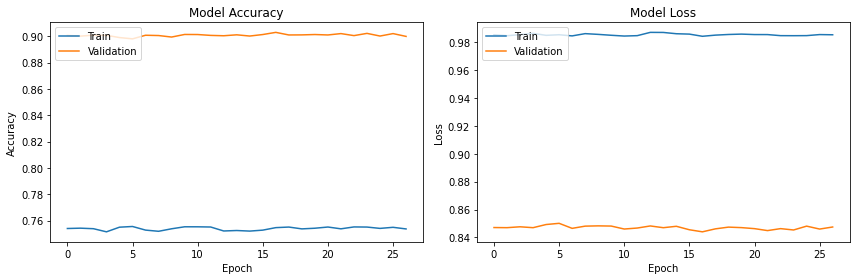

In [29]:
# GPU optimization
if isinstance(train_ds, tf.data.Dataset):
    train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
if isinstance(val_ds, tf.data.Dataset):
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

# Train the model - NO class_weight parameter!
history = model_robust.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=1,
    workers=4,
    use_multiprocessing=True
)



# After training, you can save the model
model_robust.save('final_model.h5')

# You can also save the training history
import pandas as pd
pd.DataFrame(history.history).to_csv('training_history.csv', index=False)

# If you want to visualize the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['class_out_accuracy'])
plt.plot(history.history['val_class_out_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()